# Map Matching Project - Phase 1
<div style="text-align: center">
<h1 style = "color: red"> Sharif University Of Technology</h1>
<h2 style = "color: green"> DR. Mahdieh Soleymani | DR. MohammadHossein Rohban </h2>
<h3 style = "color: cyan"> Head of Project: AmirHossein Razlighi <h3>
<h3 style = "color: cyan"> Designed By: AmirHossein Razlighi - Hamidreza Yaghoubi - Alireza Heidari - Reza Vahidi Majd - Parham Rezaei<h3>
<h3 style = "color: cyan"> Documents Designed by: Mohammad Moshtaghi Far<h3>
<h4 style = "color: white"> Ask your questions via quera</h4>
<h5> Save your file with format: STUDENT NUMBER_Phase1.ipynb or .zip </h5>
</div>

Setting up the environment

In [292]:
# %pip install pyrosm
# %pip install keplergl
# %pip install haversine
# %pip install pandas
# %pip install numpy
# %pip install scikit-spatial

In [175]:
import datetime
import numpy as np
import pandas as pd
import pyrosm
import random
import ssl
import time
import seaborn as sns
import math

from keplergl import KeplerGl
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from math import sqrt
from skspatial.objects import Line, Point
from pyrosm import OSM, get_data

In [5]:
# If you are using colab, you need to run this cell
from google.colab import output
output.enable_custom_widget_manager()

## Introduction
In this phase of project, you are going to implement a *denoising algorithm*. In many cases, when an application is dealing with _user GPS location_, in many urban areas and the places with tall towers, the GPS signal gets too noisy! This is the reason of why when you open "google maps", you see your current location with a blue circle around it. The radius of this circle shows the accuracy of your location. Sometimes, this radius is around 10m and in other areas, it goes in scale of km, making the GPS location totally unstable and unreliable! This amount of noise makes it impossible to use the data for any kind of analysis. In "ride hailing" applications like Uber, many of functionalities rely on the accuracy of GPS data. E.g. ETA estimation (Estimated time of arrival) is highly dependent on the accuracy of GPS data. In this phase, you are going to implement a denoising algorithm to make the GPS data more reliable. You will use your kowledge of Hidden Markov Models to implement this algorithm.

<div style="text-align: center">
<img src="./Images/blue_dot.jpg" height="500" width="auto" /> </br>
(Sample of GPS data with blue dot)
</div>

# Loading Pasdaran streets dataset

In this section, you will load a dataset that is prepared for you. The dataset contains some GPS locations (nodes) from Pasdaran Streets and also another dataset which contains the "streets" in Pasdaran area. By "street" we mean a pair of nodes, representing two end-points of a street in the map. These datasets are in `Data/` folder with names `pasdaran_streets.csv` and `pasdaran_nodes.csv`.

In [6]:
# Load the data
pasdaran_streets = pd.read_csv('pasdaran_streets.csv')
pasdaran_nodes = pd.read_csv('pasdaran_nodes.csv')

In [7]:
pasdaran_streets.head()

,street_id,u,v,length,oneway,u_lat,u_lon,v_lat,v_lon
0,5003747,423833948,423793584,90.570,no,35.772419,51.465652,35.771748,51.465084
1,17099043,177540293,423832815,296.273,yes,35.771034,51.464462,35.772175,51.461494
2,787945693,4429684144,423832815,62.573,no,35.772636,51.461891,35.772175,51.461494
3,687277053,177540293,423793585,97.898,no,35.771034,51.464462,35.770317,51.463833
4,36333153,9339973930,423793585,296.275,yes,35.771458,51.460865,35.770317,51.463833


In [8]:
pasdaran_nodes.head()

,id,lat,lon
0,423833948,35.772419,51.465652
1,423793584,35.771748,51.465084
2,177536927,35.776230,51.465034
3,177540293,35.771034,51.464462
4,423832815,35.772175,51.461494


In [9]:
# Visualize pasdaran_streets using kepler
KeplerGl(height=600, data={'streets': pasdaran_streets}, show_docs=False)

KeplerGl(data={'streets':        street_id            u            v   length oneway      u_lat  \
0        50…

# Creating dataset for trip

As you understood, until now, we loaded 2 datasets, `pasdaran_nodes` and `pasdaran_streets`. Now, we should create a dataset from these, such that we can use it for our trip. Each item in this dataset is called a `ride`. We will explain more as we go on.

First, we should create a **trip** for a driver. For this sake, we should choose 2 random points in our map as the source and destination of the trip. Now, we should find the streets that connect these 2 points. Each street has a length. You should find the shortest path between these 2 points (source and destination) which are in the `pasdaran_streets`. Note that this path should be the **shortest path** meaning that the sum of the lengths of streets should be minimum.

**NOTE**: You cannot use any library for finding the shortest path. You should implement it yourself, from scratch. Feel free to use any algorithm and heuristic that you want. Be creative!

**NOTE**: Be aware of "length of streets" and whether or not they are "one_way"!

In [10]:
# TODO: You should implement this from scratch and you cannot use any library (such as networkx) for finding the shortest path.
def find_shotest_path(start_node, end_node, graph):
    """
    Find the shortest path between two nodes in a graph.
    :param start_node: The start node
    :param end_node: The end node
    :param graph: The graph
    :return: The shortest path. It is a list of node_ids from start_node to end_node.
    Note that you use all of the data in "pasdaran_streets" dataset appropriately such as "street_length" and "one_way".
    """
    s = get_node_id(start_node, graph)
    t = get_node_id(end_node, graph)
    if s is None or t is None: return []

    adj, weight = create_adj(graph)
    nodes = adj.keys()
    parent = {node: None for node in nodes}
    d = {node: float('inf') for node in nodes}

    parent[s] = s
    d[s] = 0


    # todo: priority queue
    q = {node: d[node] for node in nodes}

    while q:
        x = -1
        for node, distance in q.items():
            if x == -1: x = node
            if distance < d[x]: x = node

        q.pop(x)
        for u in adj[x]:
            if d[u] > d[x] + weight[(u, x)]:
                d[u] = d[x] + weight[(u, x)]
                parent[u] = x
                q[u] = d[u]
        if x == t:
            return get_path(s, t, parent)
    return []


def get_node_id(coordinat, graph):
    u_mask = (abs(graph['u_lat'] - coordinat[0]) < 1e-8) & (abs(graph['u_lon'] - coordinat[1]) < 1e-8)
    v_mask = (abs(graph['v_lat'] - coordinat[0]) < 1e-8) & (abs(graph['v_lon'] - coordinat[1]) < 1e-8)
    if not graph[u_mask].empty: return graph[u_mask].iloc[0]['u']
    elif not graph[v_mask].empty: return graph[v_mask].iloc[0]['v']
    else: return None


def get_path(src, dst, parent):
    path = [dst]
    node = dst
    while node != src:
        if parent[node] is None: return []
        path.insert(0, parent[node])
        node = parent[node]
    return path


def create_adj(graph):
    adj, w = {}, {}
    for row in graph.itertuples():
        u, v, weight = row[2], row[3], row[4]
        adj.setdefault(u, []).append(v)
        adj.setdefault(v, []).append(u)
        w[(u, v)] = w[(v, u)] = weight

    return adj, w

You should **upload** this cell (`find_shortest_path` function) as a .py file to quera. Your code will be verified if it is actually finding the shortest path and only if it's correct, you will get the grades of this section. Be sure that you put the approriate `import ...` statements at the first of your `.py` file. Remember, you **can not** use any library that does the "shortest path" for you. (like networkx) You should implement it yourself.

**Note**: You can add other functions and codes to above cell, but you code should have the `find_shortest_path` function with exactly same signature that we have provided. Your code will be tested with calling this function. So, using other functions is not a problem, but keep in mind that the main entry for your code when we test it is the `find_shortest_path` function. Nothing else!

In [11]:
# Create a trip: Choose 2 random points as start and end points and find the shortest path between them.
# A trip is a list of node_ids from start_node to end_node.

# TODO: Implement and print out a sample trip
def create_random_trip():
    st_id, end_id = np.random.choice(pasdaran_nodes['id'].values, 2)
    st_node = pasdaran_nodes[(pasdaran_nodes['id'] == st_id)]
    end_node = pasdaran_nodes[(pasdaran_nodes['id'] == end_id)]
    return find_shotest_path((st_node.iloc[0]['lat'], st_node.iloc[0]['lon']), (end_node.iloc[0]['lat'], end_node.iloc[0]['lon']), pasdaran_streets)

trip = create_random_trip()
print(trip)

[424055334, 424055336, 4412258447, 424055339, 4268219995, 4683436115, 423793631, 4695567365, 1725415347, 9900349192, 9847389529, 9569441693, 4412258444, 4695567367, 5244624163, 1725415355, 5254232803, 4695667397, 4695667399, 4695667395, 4695667393, 806589358, 4695818010, 4695818011, 423832591, 4879764419, 10882786110, 1864300723, 10882786107, 423832805, 4695882300, 4379726030, 4695924448, 423832806, 4429680698, 4695924432, 423832804, 423832807, 4695924426, 423832798, 4695924421, 4429680700, 423832808, 4429684145, 423832809, 2106802319, 4695924408, 4695924410, 423832810, 4698557148, 4429692927, 423833953, 423832811, 4698557150]


Visualize the sampled trip (in the previous cell) on the map. Use `kepler` library for this purpose. Notice that you use keplers "timestep" attributes to create a timeline, so you can see the trip's process from _start\_node_ to _end\_node_. (You can see an output sample in the next cell)

In [12]:
#TODO: Visualize the sampled trip using kepler
def create_dataframe_from_trip(trip, time_jump):
    data = {'lat': [], 'lon': [], 'time': []}
    for index, node in enumerate(trip):
        filtered_list = pasdaran_nodes[pasdaran_nodes['id'] == node]
        data['lat'].append(filtered_list.iloc[0]['lat'])
        data['lon'].append(filtered_list.iloc[0]['lon'])
        data['time'].append(time_jump*index)
    dt = datetime.now() + timedelta(hours=3, minutes=30, seconds=30)
    data['time'] = list(map(lambda i: dt + timedelta(seconds=i), data['time']))
    return pd.DataFrame(data)


config = {
    'version': 'v1',
    'config': {
        'visState': {
            'filters': [{'dataId': ['points'], 'name': ['time']}],
            'layers': [{'type': 'point',
                'config': {'dataId': 'points', 'label': 'Point', 'columns': {'lat': 'lat', 'lng': 'lon', 'altitude': None}, 'isVisible': True,
                    'visConfig': {
                        'colorRange': {'name': 'ColorBrewer Reds-6', 'type': 'singlehue', 'category': 'ColorBrewer', 'colors': ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']}
                    }
                }, 'visualChannels': {'colorField': {'name': 'time'}}
            }]
        }, 'mapState': {'latitude': 35.76369049174373, 'longitude': 51.46450793985721, 'zoom': 13.227736077760408}
    }
}

KeplerGl(height=600, data={'points': create_dataframe_from_trip(trip, 3)}, show_docs=False, config=config)

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['points'], 'name': ['time']}…

Now, we are going to get the points in the middle of the streets. Before, we only had the intersections of the streets(start and end nodes of a section). But we know in real life, we get gps locations also in between and not necessarily in the intersections. So, we should add these points to our data. We call every entity of this type as `Ride`. A ride is defined by 3 parameters:
1. `ride_speed`: The speed of the ride which driver is driving with. We assume that the driver is driving with a constant speed.
2. `driver_gps_time`: The time interval that the driver sends his/her gps location to the server. (e.g. every 5 seconds)
3. `trip`: The specific trip that the driver is driving in. (we created this in the previous cells)

Now, you should define a function that gets these parameters and returns the locations (lat/longs) in the ride regarding the given parameters.

In [13]:
#TODO
def create_ride_from_trip(ride_speed, ride_gps_time, trip):
    dist = ride_speed * ride_gps_time
    points = []
    for i in range(len(trip)-1):
        mask_u = (pasdaran_streets['u'] == trip[i]) & (pasdaran_streets['v'] == trip[i+1])
        mask_v = (pasdaran_streets['u'] == trip[i+1]) & (pasdaran_streets['v'] == trip[i])
        if not pasdaran_streets[mask_u].empty:
            street = pasdaran_streets[mask_u]
            src = [street.iloc[0]['u_lat'], street.iloc[0]['u_lon']]
            dst = [street.iloc[0]['v_lat'], street.iloc[0]['v_lon']]
        elif not pasdaran_streets[mask_v].empty:
            street = pasdaran_streets[mask_v]
            src = [street.iloc[0]['v_lat'], street.iloc[0]['v_lon']]
            dst = [street.iloc[0]['u_lat'], street.iloc[0]['u_lon']]
        else:
            return []

        if i == 0: points.append(src)
        l = street.iloc[0]['length']

        while l > 0:
            if l < dist:
                dist -= l
                l = 0
            else:
                ratio = dist/l
                points.append([src[0]+(dst[0]-src[0])*ratio, src[1]+(dst[1]-src[1])*ratio])
                l -= dist
                dist = ride_speed * ride_gps_time
                src = points[-1]

        if i == len(trip)-2 and points[-1] != dst: points.append(dst)

    return points

See a sample ride, printed out.

In [14]:
#TODO
ride_speed, ride_gps_time = 7, 10
ride = create_ride_from_trip(ride_speed, ride_gps_time, trip)
print(ride)

[[35.764259338378906, 51.44737243652344], [35.76403393846003, 51.44809669797263], [35.763797825931285, 51.44881578927595], [35.76354608941923, 51.44952682541953], [35.76328881649114, 51.450234895159674], [35.76375562329836, 51.45060682900344], [35.764327643736735, 51.45093032159234], [35.76489904491081, 51.451255920184735], [35.76547074202288, 51.45158072814254], [35.765707752587765, 51.452022704052105], [35.766295015587, 51.452302180042466], [35.7668828148512, 51.45257993134313], [35.767469779923395, 51.4528603530454], [35.76805719224937, 51.453139345590245], [35.76864465430763, 51.45341818123453], [35.76863307281632, 51.45402580914028], [35.76840835903068, 51.4547505617102], [35.768161881052755, 51.45546228050241], [35.768101275410885, 51.45610976694739], [35.768702217352555, 51.456340898463424], [35.769294435588385, 51.45660269157197], [35.76988483909452, 51.45687065416547], [35.77048858126901, 51.45709043750092], [35.77109165052192, 51.457312988113024], [35.77169408573958, 51.45753

Visualize the sample ride on the map using `kepler` library. You should define an animation based on the order of the points in the ride, so you can play the animation in the visualization and see the ride!

In [15]:
#TODO: Visualize the sampled ride using kepler
def create_dataframe_from_array(array, time_jump):
    data = {'lat': [], 'lon': [], 'time': []}
    for index, point in enumerate(array):
        data['lat'].append(point[0])
        data['lon'].append(point[1])
        data['time'].append(time_jump*index)
    dt = datetime.now() + timedelta(hours=3, minutes=30, seconds=30)
    data['time'] = list(map(lambda i: dt + timedelta(seconds=i), data['time']))
    return pd.DataFrame(data)

KeplerGl(height=600, data={'points': create_dataframe_from_array(ride, ride_gps_time)}, show_docs=False, config=config)

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['points'], 'name': ['time']}…

Now, to complete our dataset, we need to put some random noise on the gps locations. For this sake, we easily add some random noise to the lat/longs of a created `ride`. You should define a function that gets a `ride` and adds some random noise to the lat/longs of the ride. Your function should take in 2 parameters: _ride_ and _gps\_noise\_radius_ which is the radius of the circle that you want to add noise to the gps locations. (e.g. 10 meters). The gps noise in assumed to be a normal distribution. So, assume `standard deviation` of the noise to be `gps_noise_radius`.

In [16]:
# put a random noise on each (lat, lon) location to simulate the GPS noise (suppoes GPS radius is 3 - 8 meters)
# TODO
def add_noise(ride, gps_noise_radius):
    mean = (3+8)/2 * (1e-5)
    noise = np.random.normal(mean, gps_noise_radius, size=(len(ride), 2))
    sign = np.random.choice([-1, 1], size=(len(ride), 2))
    return sign * noise + ride


# Print out a sample
noisy_ride = add_noise(ride, (5e-5)/6)
print(ride)
print(list(noisy_ride))

[[35.764259338378906, 51.44737243652344], [35.76403393846003, 51.44809669797263], [35.763797825931285, 51.44881578927595], [35.76354608941923, 51.44952682541953], [35.76328881649114, 51.450234895159674], [35.76375562329836, 51.45060682900344], [35.764327643736735, 51.45093032159234], [35.76489904491081, 51.451255920184735], [35.76547074202288, 51.45158072814254], [35.765707752587765, 51.452022704052105], [35.766295015587, 51.452302180042466], [35.7668828148512, 51.45257993134313], [35.767469779923395, 51.4528603530454], [35.76805719224937, 51.453139345590245], [35.76864465430763, 51.45341818123453], [35.76863307281632, 51.45402580914028], [35.76840835903068, 51.4547505617102], [35.768161881052755, 51.45546228050241], [35.768101275410885, 51.45610976694739], [35.768702217352555, 51.456340898463424], [35.769294435588385, 51.45660269157197], [35.76988483909452, 51.45687065416547], [35.77048858126901, 51.45709043750092], [35.77109165052192, 51.457312988113024], [35.77169408573958, 51.45753

### Different noise models
Experiment adding noise to rides using different models (PDFs) of noise. For example, you can use a uniform distribution for noise. Or you can use a normal distribution for noise. Or you can use a mixture of different distributions. You can also use a distribution that is dependent on the speed of the ride.
1. Visualize each noise model (PDF) on a plot. (You can use `matplotlib` library for this purpose)
2. Visualize the rides with different noise models on the map. (You can use `kepler` library for this purpose)
3. Compare the results of different noise models. Which one is more descriptive of the real world? Why?
4. Choose one model that you find appropriate for training your HMM on it. We will use that model for the rest of the project.

In [17]:
#TODO: Experimenting with different GPS noise radiuses
lb, ub = 3, 8
number_of_samples = 10000

uniform = np.random.uniform(lb, ub, (number_of_samples, 2))
print(list(uniform))
binary = np.random.choice([lb, ub], (number_of_samples, 2))
print(list(binary))
normal = np.random.normal((lb+ub)/2, (ub-lb)/6, (number_of_samples, 2))
print(list(normal))
normal_ride_speed = np.random.normal((lb+ub+5*((0.04*ride_speed)**2))/2, (ub-lb)/6, (number_of_samples, 2))
print(list(normal_ride_speed))
normal_20 = np.random.normal((lb+ub+5*((0.04*20)**2))/2, (ub-lb)/6, (number_of_samples, 2))
print(list(normal_20))
normal_25 = np.random.normal((lb+ub+5*((0.04*25)**2))/2, (ub-lb)/6, (number_of_samples, 2))
print(list(normal_25))
normal_30 = np.random.normal((lb+ub+5*((0.04*30)**2))/2, (ub-lb)/6, (number_of_samples, 2))
print(list(normal_30))

[array([4.59657984, 5.45909031]), array([7.55730401, 7.50641383]), array([7.4293486 , 4.68443878]), array([5.82200029, 5.19775372]), array([3.15448787, 7.19132747]), array([3.78851716, 4.71453912]), array([4.91295737, 5.65414102]), array([7.39186367, 3.7886017 ]), array([4.31128811, 6.64608053]), array([5.86102004, 3.65202602]), array([3.94971103, 3.77608821]), array([3.87526621, 3.30857871]), array([3.62183597, 3.1263155 ]), array([6.66942511, 4.82218799]), array([4.58450645, 4.93371878]), array([7.59800143, 6.49535494]), array([3.44010956, 3.59715448]), array([5.53837046, 6.49375639]), array([4.0397099 , 7.03568243]), array([6.41574394, 5.67192347]), array([5.53045455, 3.76373883]), array([4.86812951, 7.10970116]), array([4.01196631, 3.89676451]), array([4.02381135, 4.72230482]), array([3.78360842, 4.03128138]), array([3.02118753, 4.03362688]), array([3.96636778, 6.24536088]), array([6.46461902, 4.80163959]), array([7.80233678, 6.96118019]), array([6.32481965, 5.6435614 ]), array([6.

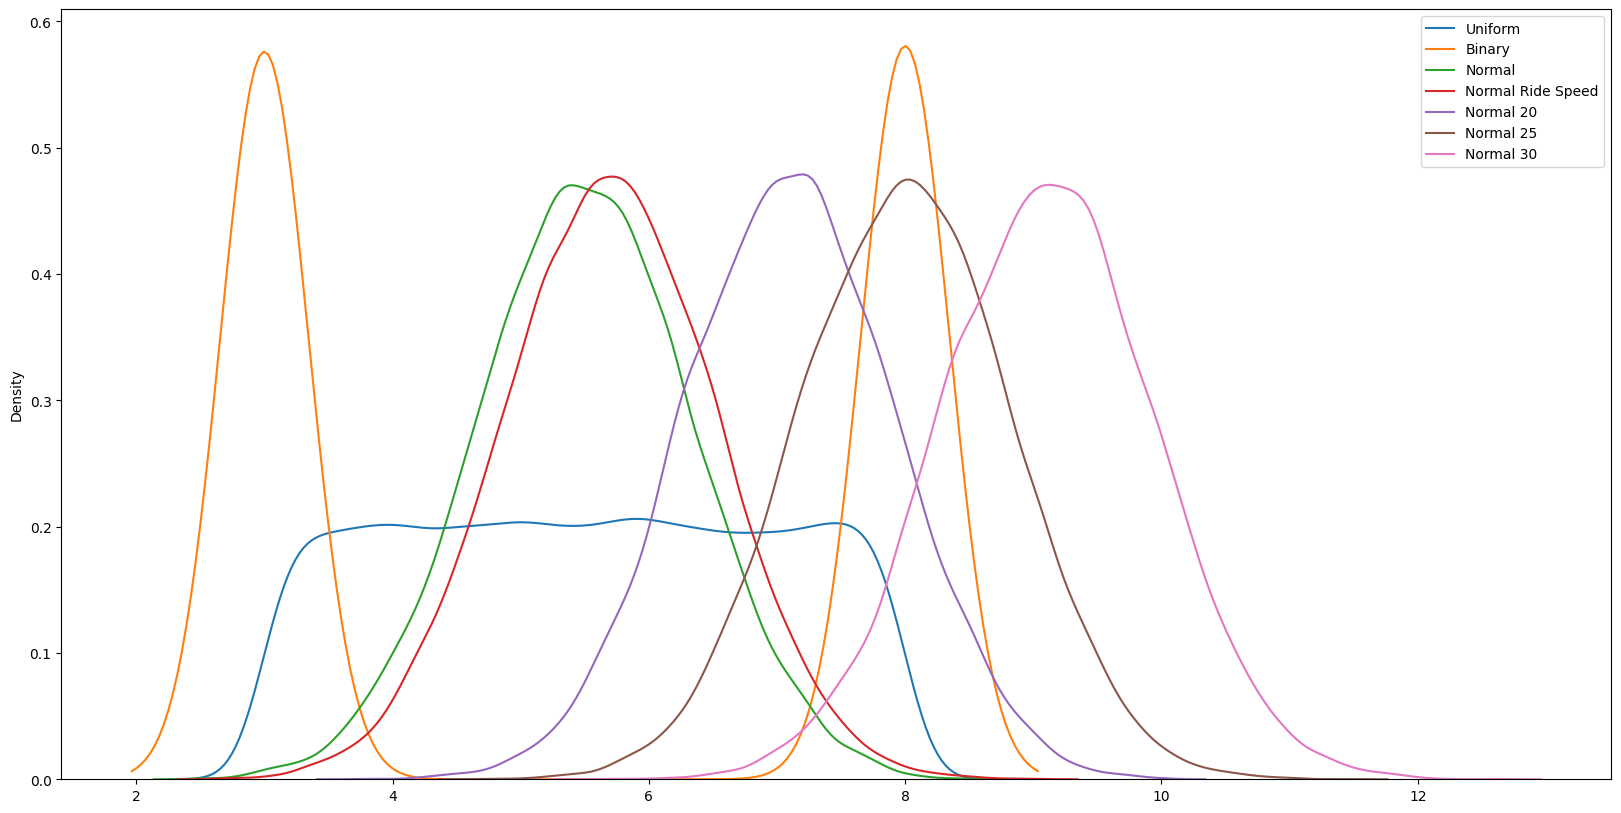

In [18]:
#TODO: Visualize the noise models using matplotlib
plt.figure(figsize=(20,10))
sns.kdeplot(uniform.flatten())
sns.kdeplot(binary.flatten())
sns.kdeplot(normal.flatten())
sns.kdeplot(normal_ride_speed.flatten())
sns.kdeplot(normal_20.flatten())
sns.kdeplot(normal_25.flatten())
sns.kdeplot(normal_30.flatten())
plt.legend(['Uniform', 'Binary', 'Normal', 'Normal Ride Speed', 'Normal 20', 'Normal 25', 'Normal 30'])
plt.show()

In [19]:
#TODO: Visualize the noise models using kepler
def add_noise(ride, dist):
    sign = np.random.choice([-1, 1], size=(len(ride), 2))
    return sign*dist[0:len(ride)]*2e-5 + ride

# Print out a sample
print(ride)
noisy_uniform = add_noise(ride, uniform)
print(list(noisy_uniform))
noisy_binary = add_noise(ride, binary)
print(list(noisy_binary))
noisy_normal = add_noise(ride, normal)
print(list(noisy_normal))
noisy_normal_ride_speed = add_noise(ride, normal_ride_speed)
print(list(noisy_normal_ride_speed))


config={
    'version': 'v1',
    'config': {
        'visState': {
            'layers': [
                {'type': 'point', 'config': {'dataId': 'noisless', 'label': 'Noiseless', 'columns': {'lat': 'lat', 'lng': 'lon', 'altitude': None}, 'isVisible': True}}
               ,{'type': 'point', 'config': {'dataId': 'uniform', 'label': 'Uniform Noise', 'columns': {'lat': 'lat', 'lng': 'lon', 'altitude': None}, 'isVisible': True}}
               ,{'type': 'point', 'config': {'dataId': 'binary', 'label': 'Binary Noise', 'columns': {'lat': 'lat', 'lng': 'lon', 'altitude': None}, 'isVisible': True}}
               ,{'type': 'point', 'config': {'dataId': 'normal', 'label': 'Normal Noise', 'columns': {'lat': 'lat', 'lng': 'lon', 'altitude': None}, 'isVisible': True}}
               ,{'type': 'point', 'config': {'dataId': 'normal_ride_speed', 'label': 'Normal Ride Speed Noise', 'columns': {'lat': 'lat', 'lng': 'lon', 'altitude': None}, 'isVisible': True}}
            ]
        }, 'mapState': {'latitude': 35.77252296102296, 'longitude': 51.45942338534628, 'zoom': 14.3}
    }
}

KeplerGl(height=600, data={'noisless': create_dataframe_from_array(ride, ride_gps_time),
                           'uniform': create_dataframe_from_array(noisy_uniform, ride_gps_time),
                           'binary': create_dataframe_from_array(noisy_binary, ride_gps_time),
                           'normal': create_dataframe_from_array(noisy_normal, ride_gps_time),
                           'normal_ride_speed': create_dataframe_from_array(noisy_normal_ride_speed, ride_gps_time)}, show_docs=False, config=config)

[[35.764259338378906, 51.44737243652344], [35.76403393846003, 51.44809669797263], [35.763797825931285, 51.44881578927595], [35.76354608941923, 51.44952682541953], [35.76328881649114, 51.450234895159674], [35.76375562329836, 51.45060682900344], [35.764327643736735, 51.45093032159234], [35.76489904491081, 51.451255920184735], [35.76547074202288, 51.45158072814254], [35.765707752587765, 51.452022704052105], [35.766295015587, 51.452302180042466], [35.7668828148512, 51.45257993134313], [35.767469779923395, 51.4528603530454], [35.76805719224937, 51.453139345590245], [35.76864465430763, 51.45341818123453], [35.76863307281632, 51.45402580914028], [35.76840835903068, 51.4547505617102], [35.768161881052755, 51.45546228050241], [35.768101275410885, 51.45610976694739], [35.768702217352555, 51.456340898463424], [35.769294435588385, 51.45660269157197], [35.76988483909452, 51.45687065416547], [35.77048858126901, 51.45709043750092], [35.77109165052192, 51.457312988113024], [35.77169408573958, 51.45753

KeplerGl(config={'version': 'v1', 'config': {'visState': {'layers': [{'type': 'point', 'config': {'dataId': 'n…

In [20]:
#TODO: Choose the best model (while you explain why you chose it)
def add_noise_to_ride(ride, ride_speed):
    lb, ub = 3, 8
    dist = np.random.normal((lb+ub+5*((0.04*ride_speed)**2))/2, (ub-lb)/6, (len(ride), 2))
    sign = np.random.choice([-1, 1], size=(len(ride), 2))
    return sign*dist*2e-5 + ride


ride_speed, ride_gps_time = 15, 9
ride = create_ride_from_trip(ride_speed, ride_gps_time, trip)
noisy_ride = add_noise_to_ride(ride, ride_speed)
print(ride)
print(list(noisy_ride))

[[35.764259338378906, 51.44737243652344], [35.76381532721863, 51.44876474385452], [35.76332556976658, 51.45013374233965], [35.76420521527322, 51.450860511319526], [35.76530755339584, 51.451487515546326], [35.76608553709694, 51.452201541076235], [35.76721830034507, 51.452739926205076], [35.76835084598746, 51.45327900887235], [35.768536766908184, 51.45433641738453], [35.7680829710399, 51.45572174732435], [35.76887391505017, 51.45640693603943], [35.77001421241763, 51.4569177505945], [35.77117777389872, 51.457344901851634], [35.77232743763102, 51.457808326175446], [35.773284482545634, 51.4587290083734], [35.77431957508381, 51.45949524525861], [35.775460112458056, 51.460007961984175], [35.77661167888431, 51.46047835037333], [35.77778874659086, 51.46084489624661], [35.778961617123514, 51.46123146407772], [35.77901840209961, 51.46125030517578]]
[array([35.76439913, 51.44749342]), array([35.76392449, 51.44888683]), array([35.76319463, 51.45025519]), array([35.76433008, 51.4509927 ]), array([35

**Explanation of my noise model:**

Using a normal distribution we add an appropriate amount of noise to each point (not too close to the original point and not too far from it). Also, in this model, we have taken `ride_speed` into account, so we have more noise at higher speeds.

Visualize a sample `ride` and its corresponding `noisy_ride` (using your selected noise model) on the map.

In [21]:
#TODO: Visualize using kepler
config={
    'version': 'v1',
    'config': {
        'visState': {
            'filters': [{'dataId': ['noisless'], 'name': ['time'],}],
            'layers': [{'type': 'point',
                'config': {'dataId': 'noisless', 'label': 'Noiseless', 'columns': {'lat': 'lat', 'lng': 'lon', 'altitude': None}, 'isVisible': True,
                    'visConfig': {'colorRange': {'name': 'ColorBrewer OrRd-6', 'type': 'sequential', 'category': 'ColorBrewer', 'colors': ['#fef0d9', '#fdd49e', '#fdbb84', '#fc8d59', '#e34a33', '#b30000']}}
                  }, 'visualChannels': {'colorField': {'name': 'time', 'type': 'timestamp'}}
             }, {'type': 'point',
                  'config': {'dataId': 'noisy', 'label': 'Noisy', 'columns': {'lat': 'lat', 'lng': 'lon', 'altitude': None}, 'isVisible': True,
                      'visConfig': {'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}}
                  }, 'visualChannels': {'colorField': {'name': 'time', 'type': 'timestamp'}}
             }]
        }, 'mapState': {'latitude': 35.76734309991244, 'longitude': 51.46375179290816, 'zoom': 14}
    }
}

KeplerGl(height=600, data={'noisless': create_dataframe_from_array(ride, ride_gps_time),
                           'noisy': create_dataframe_from_array(noisy_ride, ride_gps_time)}, show_docs=False, config=config)

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['noisless'], 'name': ['time'…

Now, we create our dataset, We create 20 noisy_rides for each trip.

In [22]:
#TODO: create and store 20 noisy_rides as a dataset for our HMM to train on it and experiment with it
rides, noisy_rides = [], []
for i in range(20):
    while True:
        t = create_random_trip()
        if t: break
    speed, time = np.random.randint([5, 2], [30, 10])
    rides.append(r := create_ride_from_trip(speed, time, t))
    noisy_rides.append(add_noise_to_ride(r, speed))

print(len(rides), len(noisy_rides))

20 20


# HMM

In this section, we want to use the dataset that we created in the previous section to train an HMM model. We want to use HMM models to  **denoise** the gps locations of the rides. We assume that the gps locations of the rides are noisy and we want to denoise them using HMM models. The observations in each _timestamp_ are the observed noisy points in the dataset.

You should implement a class (or function) named HMM which gets the noisy observations and the `streets` of the map (of course, this is not noisy. we saw that as `pasdaran_streets` in the previous section). You should calculate the transition matrix and emission matrix of the HMM model. You should also implement the `viterbi` algorithm to find the most probable sequence of hidden states (which are the points in the streets) given the noisy observations. Finally, your implementation should be capable of returning the denoised gps locations of the rides. Note that how you define your features, and your states. Be creative!

In [284]:
#TODO: Implement helper functions for your calculations
def calculate_transition_probabilities():
    transition_probs = []

    for given_street in pasdaran_streets.itertuples():
        given_u = [given_street[6], given_street[7]]
        given_v = [given_street[8], given_street[9]]
        s = []
        for street in pasdaran_streets.itertuples():
            u = [street[6], street[7]]
            v = [street[8], street[9]]
            a = np.min([((x[0]-y[0])**2 + (x[1]-y[1])**2) for x in [u, v] for y in [given_u, given_v]])
            s.append(a)

        s = [a*1e7 for a in s]
        l = 1e-1
        s = [l*np.exp(-l*a)+1e-10 for a in s]
        x = np.sum(s)
        s = [a/x for a in s]
        transition_probs.append(s)
    return transition_probs


def calculate_emmision_probabilities(observation):
    s = []
    for street in pasdaran_streets.itertuples():
        x0, y0 = street[6], street[7]
        x1, y1 = street[8], street[9]

        # line = Line.from_points([x0, y0], [x1, y1])
        # point = Point(observation)
        # projected_point = line.project_point(point)
        # f = line.distance_point(point)

        f = np.min([((observation[0]-b[0])**2 + (observation[1]-b[1])**2) for b in [[x0, y0], [x1, y1]]])
        s.append(f)

    s = [a*1e7 for a in s]
    l = 1e-1
    s = [l*np.exp(-l*a)+1e-10 for a in s]
    x = np.sum(s)
    s = [a/x for a in s]
    return s

In [285]:
# Define your HMM model
# Hint: You can assume states of your HMM model to be streets of the map. You may use other designs as well (based on your creativity)!
no_of_streets = len(pasdaran_streets)
initial_probs = [1/no_of_streets for _ in range(no_of_streets)]
transition_probs = calculate_transition_probabilities()

In [286]:
# Use Viterbi Algorithm to find the most probable set of points (denoised points)
def viterbi(observations, streets):
    no_of_streets = len(streets)
    m = []
    mle = []
    m.append([initial_probs[i] for i in range(no_of_streets)])
    for i, obs in enumerate(observations):
        i += 1
        emission_probs = calculate_emmision_probabilities([obs[0], obs[1]])
        v, e = 0, 0
        s = []
        for j in range(no_of_streets):
            x = emission_probs[j] * max([transition_probs[j][k] * m[i-1][k] for k in range(no_of_streets)])
            s.append(x)
            if v < x:
                v = x
                e = j
        m.append(s)
        mle.append(e)
    return mle

Visualize a sample denoised _ride_ using your HMM model. Put `original_points` and `denoised_points` on the map. Use different colors for each of them to make them distinct from eachother. You should use `kepler` library for this purpose.

In [289]:
#TODO: Visualize a sample noisy_ride alongside its denoised version
def project_points_to_streets(points, streets):
    projected = []
    for p, s in zip(points, streets):
        street = pasdaran_streets.iloc[s]
        u = [street['u_lat'], street['u_lon']]
        v = [street['v_lat'], street['v_lon']]
        line = Line.from_points(u, v)
        point = Point(p)
        projected_point = line.project_point(point)
        projected.append(projected_point)
    return projected


print(list(noisy_rides[0]))
mle = viterbi(noisy_rides[0], pasdaran_streets)
print(mle)
projected_points = project_points_to_streets(noisy_rides[0], mle)
print(projected_points)

KeplerGl(height=600, data={'noisy': create_dataframe_from_array(noisy_rides[0], 3),
                           'denoised': create_dataframe_from_array(projected_points, 3)}, show_docs=False)

[array([35.76296364, 51.4533938 ]), array([35.76328052, 51.45280168]), array([35.76436999, 51.45328007]), array([35.76483092, 51.452856  ]), array([35.76526852, 51.45202763]), array([35.76571686, 51.45084658]), array([35.7660055 , 51.45003729]), array([35.76674483, 51.44870279]), array([35.76682654, 51.44775186]), array([35.76707315, 51.44643356]), array([35.76753033, 51.44547768]), array([35.76756664, 51.44395339]), array([35.76709014, 51.44308238]), array([35.7673397 , 51.44205611]), array([35.76785445, 51.44152341]), array([35.76876385, 51.44091723]), array([35.76960202, 51.44036961])]
[979, 978, 876, 884, 883, 1371, 130, 1007, 343, 1330, 350, 353, 356, 361, 1790, 1788, 1787]
[Point([35.76288157, 51.45335397]), Point([35.76327059, 51.45281547]), Point([35.76419991, 51.45350823]), Point([35.76452659, 51.45271966]), Point([35.76487083, 51.45186307]), Point([35.76586785, 51.45092014]), Point([35.76625573, 51.45016658]), Point([35.76669695, 51.44868125]), Point([35.76697424, 51.44780571

KeplerGl(data={'noisy':           lat        lon                       time
0   35.762964  51.453394 2024-01-0…

# Testing your model

In this section, you should test your model. You could use your dataset (which you generated, step-by-step) until now, to implement, debug and train your model. Now, you should load `test_dataset` that we provided to you as `noisy_test_dataset.csv` and `original_test_dataset.csv`. Run your model on `noisy_test_dataset` and use `original_test_dataset` to evaluate how good you did. run your model on `noisy_test_dataset` to denoise the points. You should put the denoised points in a csv file named `denoised_test_dataset.csv` and submit it with your notebook. Also, You should report the **Mean haversine distance (MHD)** as the measaure of the loss of your model. Go through each trip in the `noisy_test_dataset` and calculate the MHD for each trip. Finally, report the average of the MHDs of all the trips in the `test_dataset` as the MHD of your model.

In [293]:
from haversine import haversine
from tqdm import tqdm

def mean_haversine_distance(denoised_points, original_points):
    m = 0
    for denoised_point, original_point in zip(denoised_points, original_points):
        m += haversine(denoised_point, original_point)
    return m/len(denoised_points)

test_dataset_noisy = pd.read_csv("noisy_test_dataset.csv")
test_dataset_original = pd.read_csv("original_test_dataset.csv")

test_dataset_original.head()

,Unnamed: 0,trip_id,index,source,destination,lat,lon,ride_speed,ride_gps_time
0,0,0,0,4429680702,4695666788,35.771816,51.461178,0.00096,0.466
1,0,0,1,4429680702,4695666788,35.771458,51.460865,0.00096,0.466
2,0,0,2,4429680702,4695666788,35.770760,51.460239,0.00096,0.466
3,0,0,3,4429680702,4695666788,35.770027,51.459633,0.00096,0.466
4,0,0,4,4429680702,4695666788,35.769318,51.459030,0.00096,0.466


In [294]:
test_dataset_noisy.head()

,Unnamed: 0,trip_id,index,source,destination,lat,lon,ride_speed,ride_gps_time
0,0,0,0,4429680702,4695666788,35.771917,51.461279,0.00096,0.466
1,0,0,1,4429680702,4695666788,35.771399,51.460806,0.00096,0.466
2,0,0,2,4429680702,4695666788,35.770759,51.460239,0.00096,0.466
3,0,0,3,4429680702,4695666788,35.769997,51.459603,0.00096,0.466
4,0,0,4,4429680702,4695666788,35.769289,51.459002,0.00096,0.466


In [296]:
# Iterate through each noisy ride and denoise it, then calculate the mean haversine distance between the denoised ride and the original ride
# Report the Average Mean Haversine Distance for all the rides in the test dataset
# This should be of order 10^-3

**How to submit**: You should submit your notebook and the `denoised_test_dataset.csv` file. Your codes are verified based on the "Mean haversine distance" value that your code gets and the `denoised_test_dataset.csv`. Also, note that for the **shortest path** section, you should have submitted the `.py` file, containing the `def find_shotest_path(start_node, end_node, graph)` function (and all of necessary imports) on quera. Your code will be verified based on the correctness of the shortest path that you find. So, you should submit these in total:
1. `STUDENT_NUMBER_Phase1.ipynb` or `.zip` file containing your notebook and the `denoised_test_dataset.csv` file.
2. `STUDENT_NUMBER_Phase1.py` file containing the `find_shortest_path` function. (Also submit this to the related section in quera)
3. Printed out Average Haversine Distance in the last cell of notebook. (This should be of order $10^{-3}$)